# Classification of Botany books in PDF format into Animal species, Plant Species or Mixed type using NLP toolkit~nltk.


1.   Training Data and Test data contains 3 columns - 'File_ID', 'Is_Mixed','Topic'
2.   Each File ID is unique and contains details of a topic with varied number of pages
3.   Each PDF needs to be read, identify the topic and determine whether it focuses on animals, plants or both
4.   For each PDF file we shall check the highest probability of a word occuring and identify the topic



## Data Loading and Reading the PDF Files into Pandas df

In [ ]:
#We will download the dataset from https://s3-ap-southeast-1.amazonaws.com/he-public-data/dataset6f31ddd.zip
#Once we unzip the dataset we will have the train.csv and test.csv
#It will also contain 2 folders - train & test which will have the respective PDF files

!wget https://s3-ap-southeast-1.amazonaws.com/he-public-data/dataset6f31ddd.zip
!unzip dataset6f31ddd.zip

In [2]:
#Let's read the train.csv and check the schema
import pandas as pd
df_train_csv = pd.read_csv('/content/dataset/train.csv')
df_train_csv.head(3)

,File_ID,Is_Mixedup,Topic
0,0x20de0,NO,Animal Species
1,0x23264,NO,Plant Species
2,0x22e2e,NO,Animal Species


**Let's perform some basic EDA on the train.csv**

In [3]:
df_train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   File_ID     12000 non-null  object
 1   Is_Mixedup  12000 non-null  object
 2   Topic       12000 non-null  object
dtypes: object(3)
memory usage: 281.4+ KB


In [4]:
df_train_csv.isnull().sum()

File_ID       0
Is_Mixedup    0
Topic         0
dtype: int64

In [5]:
df_train_csv.shape

(12000, 3)

In [6]:
df_train_csv['Is_Mixedup'].unique()

array(['NO', 'YES'], dtype=object)

In [7]:
df_train_csv['Topic'].unique()

array(['Animal Species', 'Plant Species', 'Not Applicable'], dtype=object)

In [8]:
#Removing duplicate values if any and make sure that the FileIDs are unique

#First we will be removing all duplicate rows from our data where the values are the same in all columns.
#By default, it will keep the first occurrence and remove the rest.
df_train_csv.drop_duplicates(inplace=True)
print("Shape of training data post duplicates removal:",df_train_csv.shape)

#Next, we will be removing duplicates from "File_ID" column
df_train_csv.drop_duplicates(subset=['File_ID'], inplace=True)
print("Shape of training data post duplicates removal on 'File_ID':",df_train_csv.shape)

Shape of training data post duplicates removal: (12000, 3)
Shape of training data post duplicates removal on 'File_ID': (12000, 3)


<Axes: >

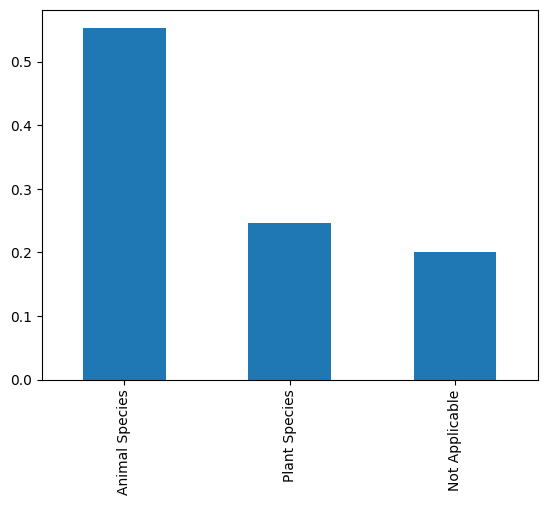

In [21]:
# check target balance
df_train_csv['Topic'].value_counts(normalize = True).plot.bar()

Thus, from above we understand that this is a supervised multi-class classification problem where we will be finding the topic of the document based on high probabilty word occurence.

From the training data we have the content of each File ID and the label informing whether it belongs to animal, plant or mixed type.

1.   If the word occurence probability is high for both plant & animal species then, classify it as 'Not Applicable'
2.   If the word occurence probability is high for plant species then, classify it as 'Plant Species'
3.   If the word occurence probability is high for animal species then, classify it as 'Animal Species'
4.   Once, the classification is done, we can provide the 'Is_Mixed' value column based on condition



### We will split the training data into train and evaluation data to check how the model performs on some unseen data

In [9]:
from sklearn.model_selection import train_test_split
x_train,x_eval=train_test_split(df_train_csv,test_size=0.33,shuffle=True,random_state=123)

print("Shape of x_train:",x_train.shape)
print("Shape of x_eval:",x_eval.shape)

Shape of x_train: (8040, 3)
Shape of x_eval: (3960, 3)


In [10]:
x_train.head()

,File_ID,Is_Mixedup,Topic
11417,0x22a37,NO,Animal Species
724,0x23e80,NO,Animal Species
2735,0x2354e,NO,Plant Species
3511,0x23845,YES,Not Applicable
11845,0x2198b,NO,Animal Species


In [11]:
x_eval.head()

,File_ID,Is_Mixedup,Topic
3744,0x214f1,NO,Animal Species
10969,0x220ed,NO,Animal Species
10,0x210cd,NO,Animal Species
1674,0x212b4,NO,Animal Species
6398,0x20cb0,YES,Not Applicable


In [12]:
print("The shape of the x_train data before restting index : ", x_train.shape)
print("The shape of the x_eval data before restting index : ", x_eval.shape)

The shape of the x_train data before restting index :  (8040, 3)
The shape of the x_eval data before restting index :  (3960, 3)


In [13]:
#We will reset the index of both x_train and x_eval data to start from 0 to n-1.
#This is done to satisfy the indexing conditions required while executing global functions which we will see in the upcoming code

x_train.reset_index(inplace=True,drop=True)
x_eval.reset_index(inplace=True,drop=True)
print("The shape of the x_train data after restting index : ", x_train.shape)
print("The shape of the x_eval data after restting index : ", x_eval.shape)

The shape of the x_train data after restting index :  (8040, 3)
The shape of the x_eval data after restting index :  (3960, 3)


In [14]:
#Let's see the difference post resetting index, we will see
#index starting from 0 to n-1 for both the train & eval dataset, which was not the case right after we split the data
x_train.head(3)

,File_ID,Is_Mixedup,Topic
0,0x22a37,NO,Animal Species
1,0x23e80,NO,Animal Species
2,0x2354e,NO,Plant Species


In [15]:
x_eval.head(3)

,File_ID,Is_Mixedup,Topic
0,0x214f1,NO,Animal Species
1,0x220ed,NO,Animal Species
2,0x210cd,NO,Animal Species


###In order to perform topic modelling we need to include the file contents in the df against each 'File_ID'.
**Let's Read the PDF files from our dataset!**

In [ ]:
#We will intall the required packages for reading PDF files into pandas

!pip install PyPDF2
import PyPDF2
import warnings
!pip install textract
import textract
warnings.filterwarnings("ignore",category=DeprecationWarning)
#Know more at https://pypdf2.readthedocs.io/en/3.0.0/user/extract-text.html

In [17]:
#defining the file reader function:
import numpy as np
def read_file(num_files,df):
  text_list = []
  for i in range(num_files):
    file_id = df['File_ID'][i]
    file_name = file_id + '.pdf'
    path = '/content/dataset/train/' + file_name
#Lets read our pdf for the manifesto using the PdfFileReader() function from the PyPDF2 which is a package for extracting document information such as title, author, number of pages,
#...., spliting documents page by page, merging page by page, etc.
#filename = '/content/dataset/train/0x205cc.pdf'
    open_path = open(path, 'rb')
    ind_zoology = PyPDF2.PdfReader(open_path)

    count = 0
    text  = ''

# Lets loop through, to read each page from the pdf file
    while(count < len(ind_zoology.pages)):
    # Get the specified number of pages in the document
      mani_page  = ind_zoology.pages[count]
    # Process the next page
      count += 1
    # Extract the text from the page
      text += mani_page.extract_text()

    if text != '':
      text = text
      text_list.append(text)

    else:
      textract.process(open_path, method='tesseract', encoding='utf-8', langauge='eng' )
      text_list.append(text)
  return text_list


In [18]:
#we will read the content of the PDF files and append it to the x_train & x_eval df

#Reading the contents of the x_train data
x_train['content'] = np.array(read_file(x_train.shape[0],x_train))
x_train.head()

,File_ID,Is_Mixedup,Topic,content
0,0x22a37,NO,Animal Species,Biological Research Labs\n Dolphins swim by mo...
1,0x23e80,NO,Animal Species,Biological Research Labs\nCuckoos are birds in...
2,0x2354e,NO,Plant Species,Biological Research Labs\n Dole ceased its ca...
3,0x23845,YES,Not Applicable,Biological Research Labs\nIt mostly inhabits r...
4,0x2198b,NO,Animal Species,"Biological Research Labs\n of Animal Science, ..."


In [19]:
#Reading the contents of the x_eval data
x_eval['content'] = np.array(read_file(x_eval.shape[0],x_eval))
x_eval.head()

,File_ID,Is_Mixedup,Topic,content
0,0x214f1,NO,Animal Species,Biological Research Labs\nToday there are only...
1,0x220ed,NO,Animal Species,Biological Research Labs\n They still needed t...
2,0x210cd,NO,Animal Species,Biological Research Labs\nPoaceae () or Gramin...
3,0x212b4,NO,Animal Species,Biological Research Labs\n The fancy rat and w...
4,0x20cb0,YES,Not Applicable,Biological Research Labs\nHummingbirds are bir...


Now, once the PDF contents are read, we will proceed for text cleaning, normalization and preprocessing to format it in a way the ML models can interpret

#Data Pre-processing and Cleaning

In [31]:
#Downloading the required packages

import nltk
nltk.download('punkt') #resource 'punkt' is required for word_tokenizer
nltk.download('wordnet') #need 'wordnet' corpus for using this lemmatizer
nltk.download('averaged_perceptron_tagger') #need for POS(Parts Of Speech) tagger
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We will examine how each tokenizer performs and whether we should lemmatize or stem a text.

We shall perform it using a single doc and then decide which one to use for the whole doc set

In [ ]:
#Let's take a text from x_train dataset
sentence = x_train['content'][0]
sentence

In [24]:
#WordNet tokenizer
word_token=nltk.word_tokenize(sentence)
print(word_token)

['Biological', 'Research', 'Labs', 'Dolphins', 'swim', 'by', 'moving', 'their', 'tail', 'fin', 'and', 'rear', 'body', 'vertically', ',', 'while', 'their', 'flippers', 'are', 'mainly', 'used', 'for', 'steering', 'Some', 'species', 'log', 'out', 'of', 'the', 'water', ',', 'which', 'may', 'allow', 'them', 'to', 'travel', 'faster', 'Their', 'skeletal', 'anatomy', 'allows', 'them', 'to', 'be', 'fast', 'swimmers', 'All', 'species', 'have', 'a', 'dorsal', 'fin', 'to', 'prevent', 'themselves', 'from', 'involuntarily', 'spinning', 'in', 'the', 'water', 'Some', 'dolphins', 'are', 'adapted', 'for', 'diving', 'to', 'great', 'depths', 'In', 'addition', 'to', 'their', 'streamlined', 'bodies', ',', 'some', 'can', 'selectively', 'slow', 'their', 'heart', 'rate', 'to', 'conserve', 'oxygen', 'Some', 'can', 'also', 're-route', 'blood', 'from', 'tissue', 'tolerant', 'of', 'water', 'pressure', 'to', 'the', 'heart', ',', 'brain', 'and', 'other', 'organs', 'Their', 'hemoglobin', 'and', 'myoglobin', 'store', 

In [37]:
#RegexpTokenizer

regex_tokenizer = RegexpTokenizer(r'\w+')
tokens_= regex_tokenizer.tokenize(sentence)
print(tokens_)

['Biological', 'Research', 'Labs', 'Dolphins', 'swim', 'by', 'moving', 'their', 'tail', 'fin', 'and', 'rear', 'body', 'vertically', 'while', 'their', 'flippers', 'are', 'mainly', 'used', 'for', 'steering', 'Some', 'species', 'log', 'out', 'of', 'the', 'water', 'which', 'may', 'allow', 'them', 'to', 'travel', 'faster', 'Their', 'skeletal', 'anatomy', 'allows', 'them', 'to', 'be', 'fast', 'swimmers', 'All', 'species', 'have', 'a', 'dorsal', 'fin', 'to', 'prevent', 'themselves', 'from', 'involuntarily', 'spinning', 'in', 'the', 'water', 'Some', 'dolphins', 'are', 'adapted', 'for', 'diving', 'to', 'great', 'depths', 'In', 'addition', 'to', 'their', 'streamlined', 'bodies', 'some', 'can', 'selectively', 'slow', 'their', 'heart', 'rate', 'to', 'conserve', 'oxygen', 'Some', 'can', 'also', 're', 'route', 'blood', 'from', 'tissue', 'tolerant', 'of', 'water', 'pressure', 'to', 'the', 'heart', 'brain', 'and', 'other', 'organs', 'Their', 'hemoglobin', 'and', 'myoglobin', 'store', 'oxygen', 'in', '

**We can observe from above that RegexpTokenizer does a better job in removing the punctuation. Thus, we will be using the same.**

We will now remove the stop words.

In [28]:
len(tokens_)

1720

In [ ]:
tokens_noStopWords = [word for word in tokens_ if word not in stopwords.words('english')]
tokens_noStopWords

In [33]:
len(tokens_noStopWords)
#We can see there is drastic reduction in the count of words in the sentence

1071

We shall now choose between Lemmatization or stemming the word tokens.

In [35]:
#Stemming using Porter Stemmer

stemmer=PorterStemmer()
stemmed_output= ' '.join([stemmer.stem(w) for w in tokens_noStopWords])
print(stemmed_output)

biolog research lab dolphin swim move tail fin rear bodi vertic flipper mainli use steer some speci log water may allow travel faster their skelet anatomi allow fast swimmer all speci dorsal fin prevent involuntarili spin water some dolphin adapt dive great depth in addit streamlin bodi select slow heart rate conserv oxygen some also rout blood tissu toler water pressur heart brain organ their hemoglobin myoglobin store oxygen bodi tissu twice concentr myoglobin hemoglobin sensori the dolphin ear specif adapt marin environ in human middl ear work imped equal outsid air low imped cochlear fluid high imped in dolphin marin mammal great differ outer inner environ instead sound pass outer ear middl ear dolphin receiv sound throat pass low imped fat fill caviti inner ear the dolphin ear acoust isol skull air fill sinu pocket allow greater direct hear underwat dolphin send high frequenc click organ known melon thi melon consist fat skull creatur contain melon larg depress thi allow dolphin p

In [36]:
#Lemmatizing using Wordnet Lemmatizer

lemmatizer = WordNetLemmatizer()
lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in tokens_noStopWords])
print(lemmatized_output)

Biological Research Labs Dolphins swim moving tail fin rear body vertically flipper mainly used steering Some specie log water may allow travel faster Their skeletal anatomy allows fast swimmer All specie dorsal fin prevent involuntarily spinning water Some dolphin adapted diving great depth In addition streamlined body selectively slow heart rate conserve oxygen Some also route blood tissue tolerant water pressure heart brain organ Their hemoglobin myoglobin store oxygen body tissue twice concentration myoglobin hemoglobin Sensory The dolphin ear specific adaptation marine environment In human middle ear work impedance equalizer outside air low impedance cochlear fluid high impedance In dolphin marine mammal great difference outer inner environment Instead sound passing outer ear middle ear dolphin receive sound throat pass low impedance fat filled cavity inner ear The dolphin ear acoustically isolated skull air filled sinus pocket allow greater directional hearing underwater Dolphins

Stemming removes most of the information and converts the words into crude base form. The results doesn't look promising. While Lemmatization keeps the meaning of the phrase intact while also helping in reducing the words to its base format.

From the above observations it is clear, we will use the below for data normalization and cleaning:

1.   RegexpTokenizer
2.   Removing StopWords
3.   Wordnet Lemmatization



In [38]:
def get_clean_data(df):

  df_preprocess=pd.DataFrame(df['content'])
  df_preprocess['clean_data']=''
  for i in range(df.shape[0]):
    tokens_= regex_tokenizer.tokenize(df['content'][i])
    tokens_noStopWords = [word for word in tokens_ if word not in stopwords.words('english')]
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in tokens_noStopWords])
    df_preprocess['clean_data'][i]=lemmatized_output

  return df_preprocess['clean_data']



In [39]:
#Getting the clean data for x_train and x_eval dataset

x_train['doc_data']=get_clean_data(x_train)
x_train.head()

,File_ID,Is_Mixedup,Topic,content,doc_data
0,0x22a37,NO,Animal Species,Biological Research Labs\n Dolphins swim by mo...,Biological Research Labs Dolphins swim moving ...
1,0x23e80,NO,Animal Species,Biological Research Labs\nCuckoos are birds in...,Biological Research Labs Cuckoos bird Cuculida...
2,0x2354e,NO,Plant Species,Biological Research Labs\n Dole ceased its ca...,Biological Research Labs Dole ceased cannery o...
3,0x23845,YES,Not Applicable,Biological Research Labs\nIt mostly inhabits r...,Biological Research Labs It mostly inhabits re...
4,0x2198b,NO,Animal Species,"Biological Research Labs\n of Animal Science, ...",Biological Research Labs Animal Science archiv...


In [40]:
x_eval['doc_data']=get_clean_data(x_eval)
x_eval.head()

,File_ID,Is_Mixedup,Topic,content,doc_data
0,0x214f1,NO,Animal Species,Biological Research Labs\nToday there are only...,Biological Research Labs Today two living spec...
1,0x220ed,NO,Animal Species,Biological Research Labs\n They still needed t...,Biological Research Labs They still needed ret...
2,0x210cd,NO,Animal Species,Biological Research Labs\nPoaceae () or Gramin...,Biological Research Labs Poaceae Gramineae lar...
3,0x212b4,NO,Animal Species,Biological Research Labs\n The fancy rat and w...,Biological Research Labs The fancy rat wild ra...
4,0x20cb0,YES,Not Applicable,Biological Research Labs\nHummingbirds are bir...,Biological Research Labs Hummingbirds bird nat...


# Feature extraction using Vectorization

##TF-IDF (term frequency-inverse document frequency) Method

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
vector_=TfidfVectorizer(stop_words='english',use_idf=True,smooth_idf=True)

def get_ifidf_vectors(df):
  train_features = df['doc_data']
  return vector_.fit_transform(train_features)

**'max_df': float or int, default=1.0 ( range is 0.0 to 1.0)**
Definition: Ignore words/terms appearing in 100% of the documents, we can tweak to keep at any value within the range e.g. 0.5,0.75 (50% or 75%)

**'min_df': float or int, default=1 (range is 0 to 1)**
Definition: Ignore words/terms that are not present in atleast all the documents (default value=1). We can tweak it as 0.5,0.05,0.75 (50%,5%,75%)

**use_idf: bool, default=True**
Enable inverse-document-frequency reweighting. If False, idf(t) = 1.

**smooth_idf: bool, default=True**
Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions.

In [42]:
x_train_tfidf_vectors = get_ifidf_vectors(x_train)
x_eval_tfidf_vectors = vector_.transform(x_eval['doc_data'])

##CounterVectorize Method

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
def get_cv_vectors(df):
  train_features = df['doc_data']
  return cv.fit_transform(train_features)

In [44]:
x_train_cv = get_cv_vectors(x_train)
x_eval_cv = cv.transform(x_eval['doc_data'])

#ML Modelling

In [45]:
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
from sklearn import metrics

model=MultinomialNB()

x_train_target = x_train['Topic']
x_eval_target =x_eval['Topic']

**Using TF-IDF vectors**

In [46]:
model.fit(x_train_tfidf_vectors, x_train_target)
predictions_tfidf = model.predict(x_eval_tfidf_vectors)
predictions_tfidf

array(['Animal Species', 'Animal Species', 'Animal Species', ...,
       'Animal Species', 'Animal Species', 'Plant Species'], dtype='<U14')

In [47]:
df_tfidf = pd.DataFrame(metrics.confusion_matrix(x_eval_target,predictions_tfidf), index=['Animal Species','Not Applicable','Plant Species'], columns=['Animal Species','Not Applicable','Plant Species'])

df_tfidf

,Animal Species,Not Applicable,Plant Species
Animal Species,2197,0,0
Not Applicable,746,3,16
Plant Species,148,0,850


In [54]:
model.classes_

array(['Animal Species', 'Not Applicable', 'Plant Species'], dtype='<U14')

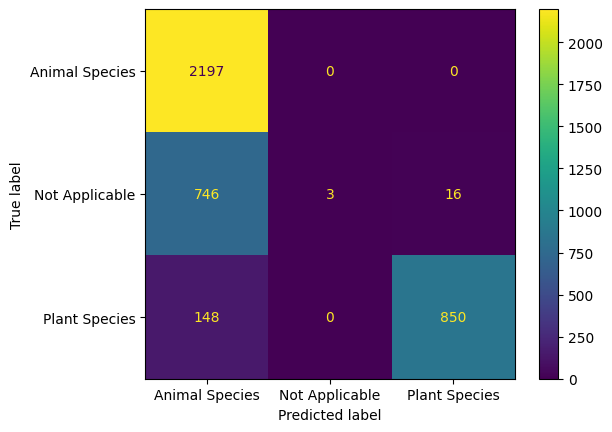

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(x_eval_target,predictions_tfidf)


**Using CounterVectors**

In [55]:
model_cv=MultinomialNB()
model_cv.fit(x_train_cv, x_train_target)
predictions_cv = model_cv.predict(x_eval_cv)
predictions_cv

array(['Animal Species', 'Animal Species', 'Animal Species', ...,
       'Animal Species', 'Animal Species', 'Plant Species'], dtype='<U14')

In [56]:
df_cv = pd.DataFrame(metrics.confusion_matrix(x_eval_target,predictions_cv), index=['Animal Species','Not Applicable','Plant Species'], columns=['Animal Species','Not Applicable','Plant Species'])

df_cv

,Animal Species,Not Applicable,Plant Species
Animal Species,2141,44,12
Not Applicable,99,638,28
Plant Species,8,18,972


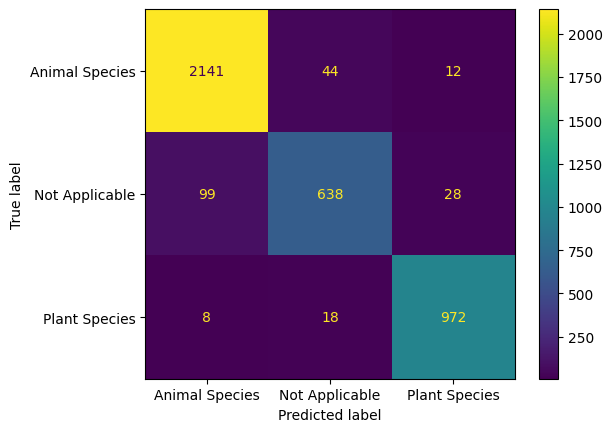

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(x_eval_target,predictions_cv)

We can see CounterVectorizer classification does a better job.
